# <u>Poland Cars For Sale</u>
#### project by Shon Shchori, Bnaya Avivi, Shachar Gerber and Noam Almog.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as mse

## About the project:

#### The Data including Over 200,000 adverts scraped from one of poland's most popular car ads site.
**Because of that, the size of the file that we started with was up to 150,000 Megabites!**  
So before we started, we took slice from the original dataset - we sorted the file by the ID of the cars, then we took every fifth row.

In [2]:
cars_df = pd.read_csv('Poland_Cars_Dataset_Presentation.csv')
print(len(cars_df))

31500


**As you'll see, you can find a lot of information,**  
So before we will analyze the data and discover some interesting stuff, let's first clean the data.

---

# <span style="color:blue">Wrangling the data:</span>
- Treat missing values
- Treat data types (converting columns to int)
- Convert prices to USD.

### <u>Treat missing values</u>
Check if there are missing values:

In [3]:
cars_df.isnull().sum().sort_values(ascending=False)

First_owner                21514
First_registration_date    19205
CO2_emissions              17603
Origin_country             13491
Vehicle_version            10715
Vehicle_generation          9360
Drive                       2235
Displacement_cm3             344
Doors_number                 245
Mileage_km                   152
Power_HP                     118
Transmission                  88
Price                          0
Vehicle_model                  0
ID                             0
Currency                       0
Condition                      0
Vehicle_brand                  0
Index                          0
Features                       0
Production_year                0
Offer_location                 0
Fuel_type                      0
Type                           0
Colour                         0
Offer_publication_date         0
Unnamed: 0                     0
dtype: int64

**First, we will delete few irrelevant Columns:**

In [4]:
cars_df.drop(columns = ['Index','First_registration_date','Vehicle_generation','Offer_location','Offer_publication_date','Unnamed: 0'], inplace = True) 

**We can see that First_owner column have the most missing values.  
Let's check what values it have:**

In [5]:
cars_df.First_owner.value_counts()

Tak    9986
Name: First_owner, dtype: int64

'Tak' in Polish means 'Yes', so we can understand that that column indicate if the car is first hand or not.  
We will fill the missing values to **'No'** and change the 'Tak' values to **'Yes'**.

In [6]:
cars_df.First_owner.fillna('No',inplace = True)
cars_df.First_owner = cars_df.First_owner.apply(lambda x: x.replace('Tak', 'Yes'))
cars_df.First_owner.value_counts()

No     21514
Yes     9986
Name: First_owner, dtype: int64

**Now, we will handle the columns that have units combined with numbers - we want only the numbers for easier analysis.**

In [7]:
cars_df.CO2_emissions.value_counts().head(5)

139 g/km    532
119 g/km    457
149 g/km    371
129 g/km    334
109 g/km    299
Name: CO2_emissions, dtype: int64

> We will extract the numbers using `.extract` function,  and convert the column to float.

In [8]:
#first we need to drop the spaces to perform the extraction.
cars_df.CO2_emissions = cars_df[cars_df.CO2_emissions.isna() == False].CO2_emissions.apply(lambda x: x.replace(' ', '')) #only for unmissing values.
cars_df.CO2_emissions = cars_df.CO2_emissions.str.extract('(\d+)').astype('float') #extracting only the numbers and converting to float.

Now we can fill missing values - we will fill them with the mode.

In [9]:
co2_Mode = cars_df.CO2_emissions.mode()[0]
cars_df.CO2_emissions.fillna(co2_Mode, inplace=True)
print("The mode is: ", co2_Mode)

The mode is:  139.0


**We will do the same proccess with the other columns.**  

In [10]:
cars_df.Mileage_km.head(5)

0    130 000 km
1    170 000 km
2     23 000 km
3    225 000 km
4    150 000 km
Name: Mileage_km, dtype: object

In [11]:
cars_df.Mileage_km = cars_df[cars_df.Mileage_km.isna() == False].Mileage_km.apply(lambda x: x.replace(' ', '')) #only for unmissing values.
cars_df.Mileage_km = cars_df.Mileage_km.str.extract('(\d+)').astype('float') #extracting only the numbers and converting to float.
cars_df.Mileage_km.fillna(cars_df.Mileage_km.mean(), inplace=True)

In [12]:
cars_df.Doors_number.value_counts()

5.0    23968
4.0     4318
3.0     1841
2.0     1117
6.0        9
7.0        1
1.0        1
Name: Doors_number, dtype: int64

**Most of cars have 5 doors, so we will fill the missing values with the mode.**

In [13]:
doors_number_Mode = cars_df.Doors_number.mode()[0]
cars_df.Doors_number.fillna(doors_number_Mode, inplace=True)

In [14]:
cars_df.Power_HP = cars_df.Power_HP.str.extract('(\d+)').astype('float') #extracting only the numbers and converting to float.
power_HP_Mode = cars_df.Power_HP.mode()[0] #the mode of this column.
cars_df.Power_HP.fillna(power_HP_Mode, inplace=True)

In [15]:
cars_df.Displacement_cm3 = cars_df[cars_df.Displacement_cm3.isna() == False].Displacement_cm3.apply(lambda x: x.replace(' ', '')) #only for unmissing values.
cars_df.Displacement_cm3 = cars_df.Displacement_cm3.str.extract('(\d+)').astype('float') #extracting only the numbers and converting to float.
displacement_Mode = cars_df.Displacement_cm3.mode()[0]
cars_df.Displacement_cm3.fillna(displacement_Mode, inplace=True)

In [16]:
transmission_Mode = cars_df.Transmission.mode()[0]
cars_df.Transmission.fillna(transmission_Mode, inplace=True)

In [17]:
drive_Mode = cars_df.Drive.mode()[0]
cars_df.Drive.fillna(drive_Mode, inplace=True)

**We can see that there is column called 'Currency':**

In [18]:
cars_df.Currency.value_counts()

PLN    31447
EUR       53
Name: Currency, dtype: int64

Let's convert it all to 'USD' for easier understanding.  
we will convert by the rate: `1 PLN = 0.27 USD, 1 EUR = 1.22 USD`

In [19]:
def Currency_Convert(currency,value): #function that converts price by the currency type.
    if currency == 'PLN':
        return value*0.27
    else:
        return value*1.22

In [20]:
newPrice = pd.DataFrame(cars_df.Price.copy(deep = False)) #new DataFrame that will help us with the new prices placement.
for row in range(0,len(cars_df)):
    newPrice.Price[row] = Currency_Convert(cars_df.Currency[row],cars_df.Price[row])
cars_df.Price = newPrice.Price #replace the original prices with the converted ones.

Now, since we converted all the prices to USD, the column 'Currency' is no longer needed.

In [21]:
cars_df.drop(columns = ['Currency'], inplace = True)

**We can't fill the columns 'Origin_country' and 'Vehicle_version' because there is no pattern to fill it,  
so we will use the word 'Unknown' to fill the missing values.**

In [22]:
cars_df.Origin_country.fillna('Unknown', inplace=True)
cars_df.Vehicle_version.fillna('Unknown', inplace=True)

**The dataset contains <u>'Features'</u> column, which indicate what features each car have.**   
This columns contain list which holds any special features the car have.  
<u>We chose 4 features and extracted them from the list to four new columns.</u>

In [23]:
#each of those variables is new dataframe which indicate if the car have the feature or not (bool value).
sunroof = pd.DataFrame(cars_df.Features.str.contains("Sunroof"))
sunroof.rename(columns={"Features": "Sunroof"}, inplace = True)
alarm = pd.DataFrame(cars_df.Features.str.contains("Alarm"))
alarm.rename(columns={"Features": "Alarm"}, inplace = True)
esp = pd.DataFrame(cars_df.Features.str.contains("ESP"))
esp.rename(columns={"Features": "ESP"}, inplace = True)
heated_seats = pd.DataFrame(cars_df.Features.str.contains("Heated front seats"))
heated_seats.rename(columns={"Features": "Heated Seats"}, inplace = True)

Now, we will connect the new dataframes to our dataframe, using `concat` function.

In [24]:
cars_df = pd.concat([cars_df,sunroof],axis=1)
cars_df = pd.concat([cars_df,alarm],axis=1)
cars_df = pd.concat([cars_df,esp],axis=1)
cars_df = pd.concat([cars_df,heated_seats],axis=1)

After we did that, the column 'Features' is no longer needed.

In [25]:
cars_df.drop(columns='Features', inplace=True)

### After the changes, the missing values now is:

In [26]:
cars_df.isnull().sum().sort_values(ascending=False)

Heated Seats        0
Fuel_type           0
Price               0
Condition           0
Vehicle_brand       0
Vehicle_model       0
Vehicle_version     0
Production_year     0
Mileage_km          0
Power_HP            0
Displacement_cm3    0
CO2_emissions       0
ESP                 0
Drive               0
Transmission        0
Type                0
Doors_number        0
Colour              0
Origin_country      0
First_owner         0
Sunroof             0
Alarm               0
ID                  0
dtype: int64

**<u>after our fixes, those our data types:</u>**

In [27]:
cars_df.dtypes.sort_values(ascending=False)

Type                 object
Vehicle_version      object
Fuel_type            object
Vehicle_brand        object
Drive                object
Transmission         object
Vehicle_model        object
Colour               object
Origin_country       object
First_owner          object
Condition            object
Doors_number        float64
Displacement_cm3    float64
Power_HP            float64
Mileage_km          float64
CO2_emissions       float64
Price                 int64
ID                    int64
Production_year       int64
ESP                    bool
Sunroof                bool
Alarm                  bool
Heated Seats           bool
dtype: object

---

### <u>Outliers:</u>

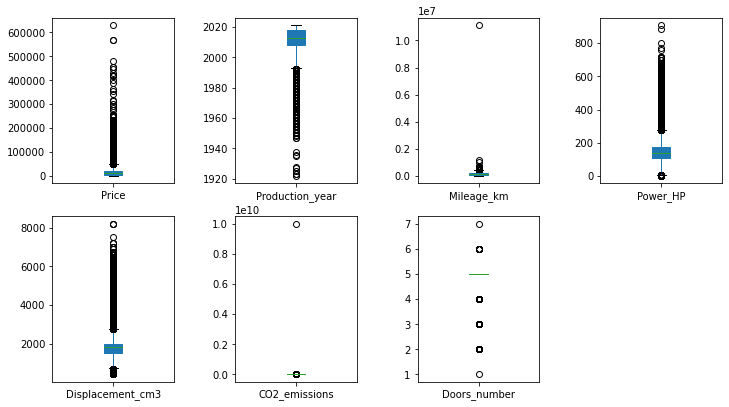

In [28]:
df_to_plot = cars_df.select_dtypes(include=np.number)
df_to_plot = df_to_plot.drop(columns = 'ID')
df_to_plot.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

#### We will handle the outliers.
The price doesn't bother us because the range make sense.

In [29]:
print("The number of cars with price bigger then 400,000 is: {:,.0f}".format(len(cars_df[cars_df.Price > 400000])))

The number of cars with price bigger then 400,000 is: 12


**Each of the following cels will presents whe number of outliers (of range we chose based on the boxplots) and deleting of those outliers.**

In [30]:
print("The number of cars made before 2000 is: {:,.0f}".format(len(cars_df[cars_df.Production_year < 2000])))
cars_df = cars_df[cars_df.Production_year >= 2000].reset_index(drop=True)

The number of cars made before 2000 is: 871


In [31]:
print("The number of cars with Mileage bigger then 300,000 is: {:,.0f}".format(len(cars_df[cars_df.Mileage_km > 300000])))
cars_df = cars_df[cars_df.Mileage_km <= 300000].reset_index(drop=True)

The number of cars with Mileage bigger then 300,000 is: 1,101


In [32]:
print("The number of cars with Power HP bigger then 350 is: {:,.0f}".format(len(cars_df[cars_df.Power_HP > 350])))
cars_df = cars_df[cars_df.Power_HP <= 350].reset_index(drop=True)

The number of cars with Power HP bigger then 350 is: 976


In [33]:
print("The number of cars with Displacement bigger then 3,000 is: {:,.0f}".format(len(cars_df[cars_df.Displacement_cm3 > 3000])))
cars_df = cars_df[cars_df.Displacement_cm3 <= 3000].reset_index(drop=True)

The number of cars with Displacement bigger then 3,000 is: 599


In [34]:
print("The number of cars with CO2 emissions bigger then 230 is: {:,.0f}".format(len(cars_df[cars_df.CO2_emissions > 230])))
cars_df = cars_df[cars_df.CO2_emissions <= 230].reset_index(drop=True)

The number of cars with CO2 emissions bigger then 230 is: 152


In [35]:
print("The number of cars with more doors then 5 is: {:,.0f}".format(len(cars_df[cars_df.Doors_number > 5.0])))
cars_df = cars_df[cars_df.Doors_number <= 5].reset_index(drop=True)

The number of cars with more doors then 5 is: 9


**The boxplots after changes:**

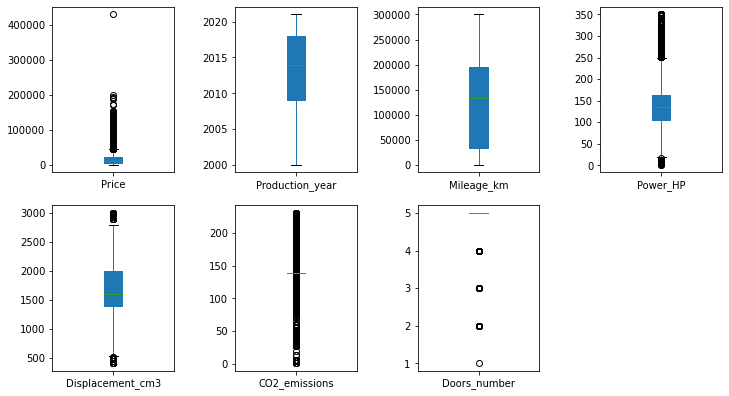

In [36]:
df_to_plot = cars_df.select_dtypes(include=np.number)
df_to_plot = df_to_plot.drop(columns = 'ID')
df_to_plot.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

---

# <span style="color:blue">Understanding the Data:</span>


Let's use pivot table, to start with some details and averages (we'll show only three rows).

In [37]:
cars_df.pivot_table(['Production_year','CO2_emissions','Price','Mileage_km', 'Power_HP', 'Displacement_cm3','Doors_number'],'Vehicle_brand',margins=True).tail(3)

,CO2_emissions,Displacement_cm3,Doors_number,Mileage_km,Power_HP,Price,Production_year
Vehicle_brand,,,,,,,
Volvo,139.306509,1988.794083,4.719527,135486.893286,180.467456,24775.044970,2013.968047
Škoda,132.110888,1535.571142,4.959252,108263.958673,127.541082,16496.065464,2015.543086
All,138.968840,1731.687140,4.704195,123738.530395,141.244531,16799.606613,2013.430232


We can learn about the CO2 emmisions average, the milage average, average price, etc.

---

# <span style="color:blue">The Polish people's best sellers and the vehicles' prices in Poland</span>

### Let's first understand what brands the polish people likes to ride on.
we will use `countplot` to do it.

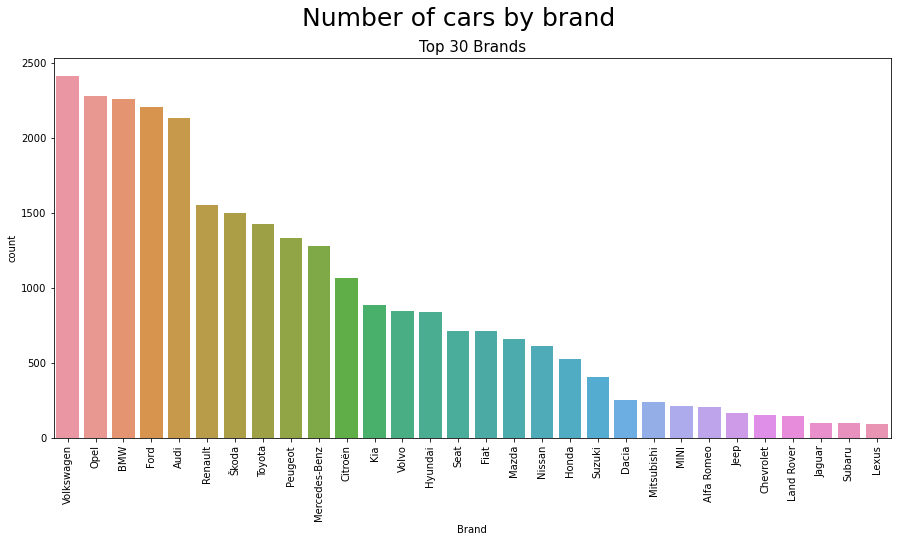

In [38]:
plt.figure(figsize=(15,7))
sns.countplot(x='Vehicle_brand', data=cars_df, order = cars_df['Vehicle_brand'].value_counts().head(30).index).tick_params(axis='x', rotation=90)
plt.xlabel("Brand");
plt.suptitle("Number of cars by brand", fontsize = 25);
plt.title("Top 30 Brands", fontsize = 15);

## You can see that poland supports local production: 
Volkswagen, Opel, BMW, Audi, Renault, Skoda, Peugeot and Mercedes-Benz, <u>8 out of the top 10 brands</u>, are European brands and Poland's neighbors.  
**We can see it by the number of cars by origin country as well:**

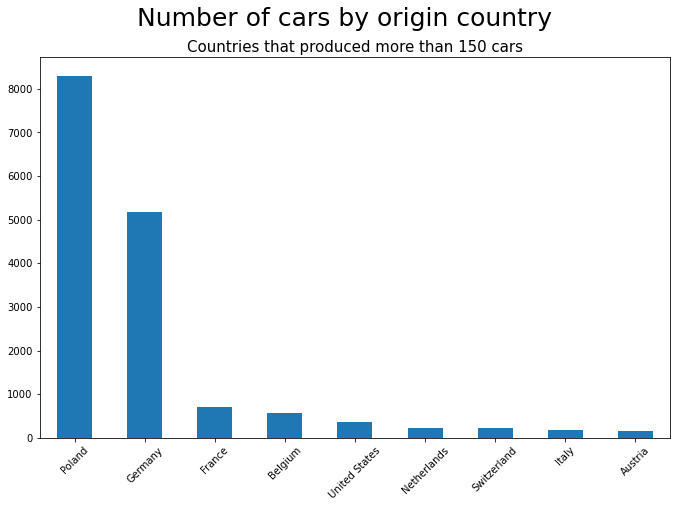

In [39]:
country_number = cars_df.Origin_country.value_counts()
country_number.drop('Unknown',inplace = True) #We don't want to see 'Unknown' in our plot.
plt.figure(figsize=(15,7))
country_number[country_number>150].plot(kind='bar',figsize=(11.3,7)).tick_params(axis='x', rotation=45)
plt.suptitle("Number of cars by origin country", fontsize = 25);
plt.title("Countries that produced more than 150 cars", fontsize = 15);

### Let's talk about prices:

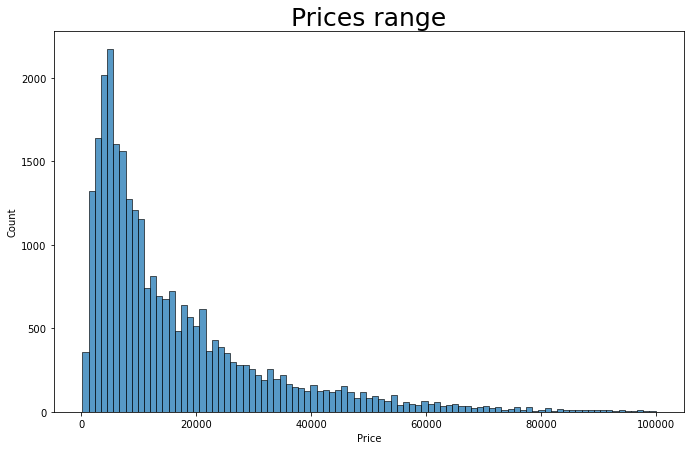

In [40]:
priceplot = cars_df[cars_df.Price < 100000].Price #only cars cheaper then $70,000
plt.figure(figsize=(11.3,7))
plt.title("Prices range", fontsize = 25);
#plt.xlim(0,70000)
sns.histplot(priceplot);

In [41]:
meanprice = cars_df.Price.mean()
print("The avarage price is: ${:,.2f}".format(meanprice))

The avarage price is: $16,799.61


## The avarage price is 16,799 and most of the cars costs less that 80,000.

In [42]:
print("The most expansive cars in Poland are:")
cars_df.groupby('Vehicle_brand').Price.mean().sort_values(ascending=False).head(5).map('${:,.2f}'.format)

The most expansive cars in Poland are:


Vehicle_brand
McLaren       $430,785.00
Alpine         $87,911.33
Porsche        $67,843.88
Maserati       $58,749.71
Land Rover     $54,070.30
Name: Price, dtype: object

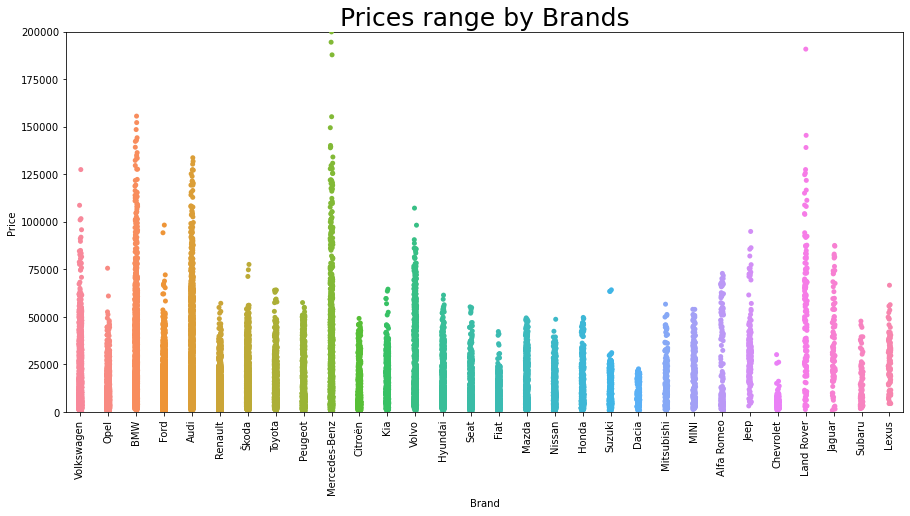

In [43]:
plt.figure(figsize=(15,7))
plt.ylim(0,200000)
sns.stripplot(x="Vehicle_brand", y="Price", jitter=0.05, data=cars_df,order = cars_df['Vehicle_brand'].value_counts().head(30).index).tick_params(axis='x', rotation=90)
plt.xlabel("Brand");
plt.title("Prices range by Brands", fontsize = 25);

>From this plot we can see the prices range for each brand - we can see that **Mercedes-Benz** have wide price range while **Chevrolet** have thin price range.

>We can learn about the Highest price for each brand as well - for example, **Land Rover's** most expensive car is about three times bigger than **Mitsubishi's** mose expensive car 

---

# <span style="color:blue">Let's talk about CO2 emmisions.</span>

#### we saw that Poland's average is 139 g/km, remember that number and and try to guess europe's average.  
**But before we'll reach there, let's understand what CO2 emmisions is:**
<div>
<img src='whatisco2emissions.png' width="700"/>
</div>

[Source: icar](https://www.icar.co.il/%D7%A8%D7%9B%D7%91_%D7%99%D7%A8%D7%95%D7%A7_-_%D7%9E%D7%9B%D7%95%D7%A0%D7%99%D7%95%D7%AA_%D7%95%D7%90%D7%99%D7%9B%D7%95%D7%AA_%D7%94%D7%A1%D7%91%D7%99%D7%91%D7%94/%D7%A9%D7%90%D7%9C%D7%95%D7%AA_%D7%95%D7%AA%D7%A9%D7%95%D7%91%D7%95%D7%AA:_%D7%AA%D7%A7%D7%A0%D7%99_%D7%94%D7%96%D7%99%D7%94%D7%95%D7%9D_%D7%A9%D7%9C_%D7%90%D7%99%D7%A8%D7%95%D7%A4%D7%94/)

#### After we understood what it is, let's see whats happening in Poland:

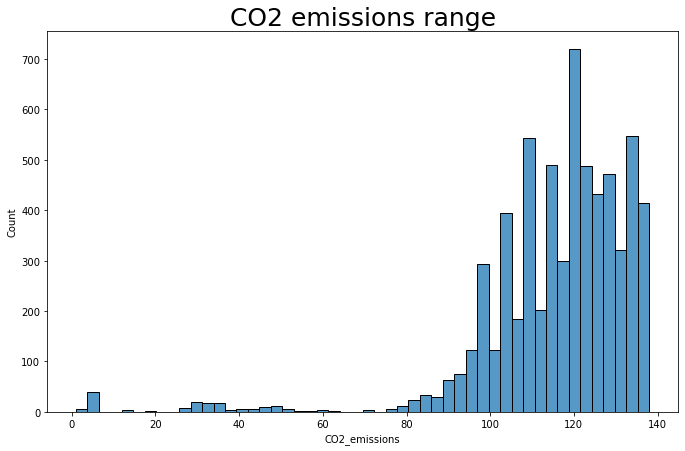

In [44]:
co2plot = cars_df[cars_df.CO2_emissions < 139].CO2_emissions
plt.figure(figsize=(11.3,7)) 
sns.histplot(co2plot, bins = 50);
plt.title("CO2 emissions range", fontsize = 25);

### What is the average in Europe? what is the goal that car manufacturers needs to reach to?


<div>
<img src='CO2average.png' width="700"/>
</div>


## <u><span style="color:red">The average is 122 g/km!</span></u>
#### **You can see how poland's consumption co2 per capita is quite high, compare to other countries:**

[Source: european environment agency](https://www.eea.europa.eu/highlights/average-co2-emissions-from-new-cars-vans-2019)
<div>
<img src='consumption-co2-per-capita.png' width="700"/>
</div>

#### **And compare to Israel:**

<div>
<img src='co-emissions-per-capita_chart.png' width="700"/>
</div>

[Source: Our World In Data Website](https://ourworldindata.org/co2/country/poland?country=POL~ISR)

#### **We can see the "Green Cars" precentage as well:**

In [45]:
pre = len(cars_df[cars_df.Fuel_type == 'Electric'])
pre += len(cars_df[cars_df.Fuel_type == 'Hybrid'])
pre = (pre/(len(cars_df)))*100
print("The ""Green Cars"" precentage is {:.3f}%".format(pre), ", quite low.")

The Green Cars precentage is 4.235% , quite low.


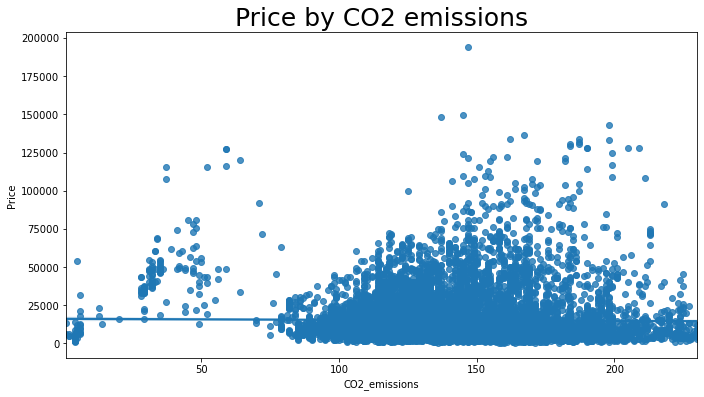

In [46]:
plt.figure(figsize=(11.3,6))
sns.regplot(data=cars_df[cars_df.CO2_emissions != 139],x='CO2_emissions',y='Price')
plt.title("Price by CO2 emissions", fontsize = 25);

## CO2 emissions is not a consideration in Poland's cars market.
#### We recommend that the Polish government give benefits in the purchase of Hybrid/Green vehicles.

---

# <span style="color:blue">Fuel types and prices</span>

In [47]:
cars_df.Fuel_type.value_counts().sort_values(ascending=False)

Gasoline          12962
Diesel            12668
Gasoline + LPG      970
Hybrid              954
Electric            223
Gasoline + CNG       15
Name: Fuel_type, dtype: int64

**You can see the fuel prices in Poland:**

<div>
<img src='Poland_fuel_prices.png' width="700"/>
</div>

[Source: Poland - fuel trends](https://autotraveler.ru/en/poland/trend-price-fuel-poland.html#.YKp726gzY2w)

> We can see that the most common type of fuel is the same as in Israel, the prices are quite the same and fuel additives are not preferred in Poland.

---

# <span style="color:blue">Engine horsepower</span>

<AxesSubplot:xlabel='Power_HP', ylabel='Count'>

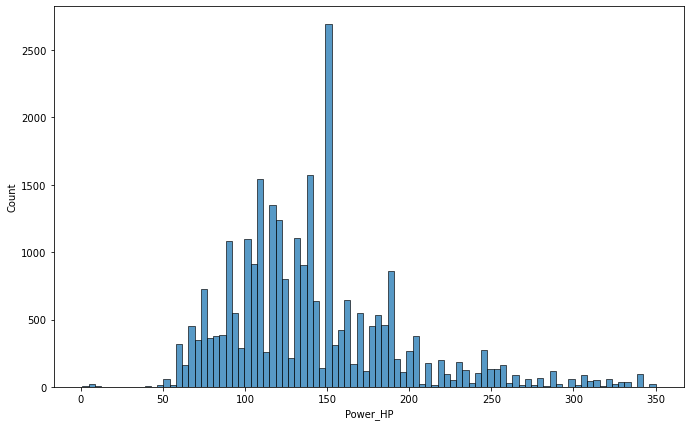

In [48]:
powerplot = cars_df.Power_HP
plt.figure(figsize=(11.3,7)) 
sns.histplot(powerplot)

---

# <span style="color:blue">Correlations</span>

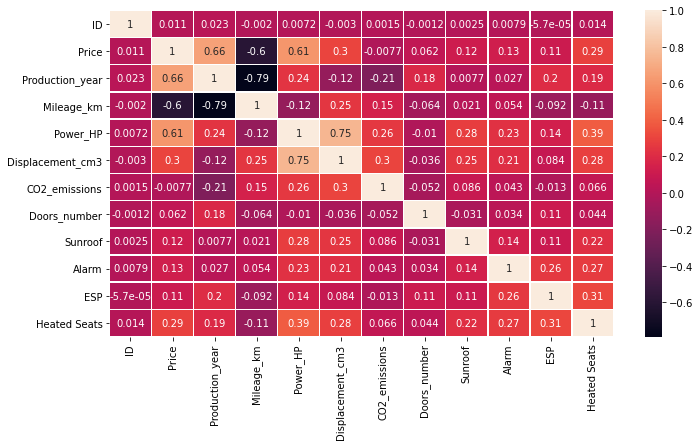

In [49]:
corr = cars_df.corr(method = 'pearson')
plt.figure(figsize=(11.3,6)) 
sns.heatmap(corr, annot = True, linewidths=0.5);

### Let's focus on the price correlations.

In [50]:
print("The correlations between 'Price' and any other column is:")
corr.Price.sort_values(ascending=False)

The correlations between 'Price' and any other column is:


Price               1.000000
Production_year     0.660907
Power_HP            0.611741
Displacement_cm3    0.302492
Heated Seats        0.290423
Alarm               0.130312
Sunroof             0.115842
ESP                 0.111631
Doors_number        0.062048
ID                  0.011064
CO2_emissions      -0.007743
Mileage_km         -0.598827
Name: Price, dtype: float64

> We can see that besides Production year and Milage (with make sense), there is no strong correlations involving the price.  
(have a look on the correlation with CO2 emissions)

---

# <span style="color:blue">Price Prediction</span>

### We will predict car's prices. Let's use Decision Tree Classifier Model to do it.

First, we will convert our columns to categories:

In [51]:
obj_col = cars_df.select_dtypes(include='object')
for col in obj_col.columns:
    cars_df[col] = cars_df[col].astype('category').cat.codes

In [52]:
bool_col = cars_df.select_dtypes(include='bool')
for col in bool_col.columns:
    cars_df[col] = cars_df[col].astype('category').cat.codes

**We will choose features:**
>**Note:** because of the weak correlation between the price and our features, we decided to exclude them from the prediction.

In [53]:
features = ['Condition', 'Vehicle_brand','Vehicle_model','Production_year', 'Mileage_km']
x = cars_df[features] #The features which will predict the target.
y = cars_df['Price'] #The target is the Salary of the player.

In [54]:
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size=0.3, random_state=1) 

In [55]:
x_test.head(5)

,Condition,Vehicle_brand,Vehicle_model,Production_year,Mileage_km
1303,1,5,490,2010,138883.0
20212,1,37,170,2014,126000.0
3842,1,5,490,2002,234000.0
4194,1,49,553,2012,99000.0
14934,0,24,552,2021,5.0


In [56]:
y_test.head(5)

1303      7533
20212     7803
3842      2349
4194      2943
14934    38313
Name: Price, dtype: int64

#### Before we predict the prices, let's check the Standard Deviation (STD):

In [57]:
print("The STD is : ${:,.3f}".format(np.std(cars_df.Price)))

The STD is : $17,730.448


#### Now, we can choose the model and train it.

In [58]:
model = sk.tree.DecisionTreeClassifier(max_depth=10, random_state = 1)
model.fit(x_train, y_train)
prediction = model.predict(x_test)

In [59]:
pred_df = pd.DataFrame(columns = ['True Price', 'Predictions'])
pred_df['True Price'] = y_test
pred_df = pred_df.reset_index(drop=True)
pred_df['Predictions'] = prediction

In [60]:
pred_df['Mistake'] = abs(pred_df['True Price'] - pred_df['Predictions']) #the gap between the true and the predict salary.
pred_mse = pred_df.Mistake.mean()
pred_df['Predictions'] = pred_df['Predictions'].map('${:,.2f}'.format) #format the values to nicer way to read.
pred_df['True Price'] = pred_df['True Price'].map('${:,.2f}'.format)
pred_df['Mistake'] = pred_df['Mistake'].map('${:,.2f}'.format)
pred_df.head()

,True Price,Predictions,Mistake
0,"$7,533.00","$7,803.00",$270.00
1,"$7,803.00","$10,773.00","$2,970.00"
2,"$2,349.00","$1,863.00",$486.00
3,"$2,943.00","$5,373.00","$2,430.00"
4,"$38,313.00","$20,385.00","$17,928.00"


> You can see that the mistakes are quite low!

In [61]:
print("The MSE is : ${:,.3f}".format(pred_mse))

The MSE is : $5,829.519


> The MSE is low, compare to the STD.

In [62]:
#text_representation = tree.export_text(model,feature_names=features) #depth 10, quite long...
#print(text_representation)

# <span style="color:blue">Thanks for listening!</span>